In [2]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import warnings
warnings.simplefilter(action="ignore")

In [3]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [4]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [5]:
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["adjclose"] = price["adjclose"].shift(5)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.10it/s]


In [48]:
model_start = 2010
model_end = 2011
backtest_end = 2025

In [95]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = factors_df.merge(price[["date","ticker","adjclose"]],on="date",how="left")
        price["year"] = price["date"].dt.year
        price["week"] = [x.week for x in price["date"]]
        price["y"] = price["adjclose"].shift(-5)
        price["momentum"] = price["adjclose"].pct_change(5)
        price["volatility"] = price["adjclose"].pct_change().rolling(5).std()
        delta = price["adjclose"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(5).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(5).mean()
        rs = gain / loss
        price["rsi"] = 100 - (100 / (1 + rs))
        fast_ema = price["adjclose"].ewm(span=12, adjust=False).mean()
        slow_ema = price["adjclose"].ewm(span=26, adjust=False).mean()
        price["macd"] = fast_ema - slow_ema
        rolling_mean = price["adjclose"].rolling(5).mean()
        rolling_std = price["adjclose"].rolling(5).std()
        price["bollinger_upper"] = rolling_mean + (2 * rolling_std)
        price["bollinger_lower"] = rolling_mean - (2 * rolling_std)
        price["coev"] = rolling_std/rolling_mean
        price["sharpe"] = (
            price["adjclose"].pct_change(5).rolling(5).mean() /
            price["adjclose"].pct_change(5).rolling(5).std()
        )
        price["rolling"] = price["adjclose"].rolling(100).mean()/price["adjclose"] - 1
        price["hybrid"] = price["rolling"] * (1-price["coev"])
        price["optimal"] = price["adjclose"].shift(-5)/price["adjclose"] - 1
        training_data = price[(price["year"]>=model_start) & (price["year"] < model_end)].dropna(subset=factors).dropna()
        sim = price[(price["year"]>=model_end-1) & (price["year"]<backtest_end)].dropna(subset=factors)
        # model = XGBRegressor()
        # model.fit(training_data[factors],training_data["y"])
        # sim["prediction"] = model.predict(sim[factors])
        # sim["ml"] = sim["prediction"]/sim["adjclose"] - 1
        sim = sim.merge(macro,on="date",how="left")
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:04<00:25, 17.20it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:05<00:26, 16.23it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:32<00:00, 15.23it/s]

'date'


In [96]:
signals = ["optimal","momentum","volatility","rsi","macd","bollinger_upper","bollinger_lower","sharpe","rolling","coev","hybrid"]
fields = ["date","ticker","adjclose"]

In [97]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left")[fields + signals]

simulation["year"] = simulation["date"].dt.year
simulation["week"] = [x.week for x in simulation["date"]]
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna()

simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]

In [98]:
run = True
if run:
    analysises = []
    for signal in tqdm(signals): 
        for ascending in tqdm([True,False]):
            try:
                parameters = {
                    "signal":signal,
                    "ascending":ascending,
                }
                filtered_simulation = simulation.copy()
                trades = filtered_simulation.groupby(["year","week","ticker"]).agg({signal:"first","adjclose":"first","sell_price":"last","sell_date":"last"}).reset_index()
                trades = trades.sort_values(signal,ascending=ascending).groupby(["year","week"]).first().reset_index()
                trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"] * 4
                portfolio = trades[["year","week","return"]].groupby(["year","week"]).mean().reset_index().sort_values(["year","week"])
                portfolio["return"] = portfolio["return"] + 1
                portfolio["return"] = portfolio["return"].cumprod() - 1
                portfolio['Year-week'] = portfolio["year"].astype(str) + "q" + portfolio["week"].astype(str)
                parameters["risk"] = portfolio["return"].std()
                parameters["return"] = portfolio["return"].iloc[-1]
                analysises.append(parameters)
            except Exception as e:
                print(str(e))
                continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:17<00:00,  1.55s/it]


In [99]:
a = pd.DataFrame(analysises)
a.sort_values("return",ascending=False).head(20)

,signal,ascending,risk,return
1,optimal,False,1.707683e+128,3.722651e+129
8,macd,True,1.449868e+04,3.825544e+03
18,coev,True,3.783749e+02,1.498025e+03
7,rsi,False,4.159228e+01,9.823691e+01
15,sharpe,False,6.785150e+01,8.144261e+01
4,volatility,True,4.477279e+00,8.706908e-01
17,rolling,False,4.051308e+01,3.833938e-01
21,hybrid,False,1.159299e+01,-7.864742e-01
2,momentum,True,2.549171e+00,-9.556099e-01
5,volatility,False,6.865595e+02,-9.992369e-01


In [100]:
signal = "coev"
ascending = True

In [101]:
filtered_simulation = simulation.copy()
trades = filtered_simulation.groupby(["year","week","ticker"]).agg({signal:"first","adjclose":"first","sell_price":"last","sell_date":"last"}).reset_index()
trades = trades.sort_values(signal,ascending=ascending).groupby(["year","week"]).first().reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"] * 4
portfolio = trades[["year","week","return"]].groupby(["year","week"]).mean().reset_index().sort_values(["year","week"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-week'] = portfolio["year"].astype(str) + "w" + portfolio["week"].astype(str)

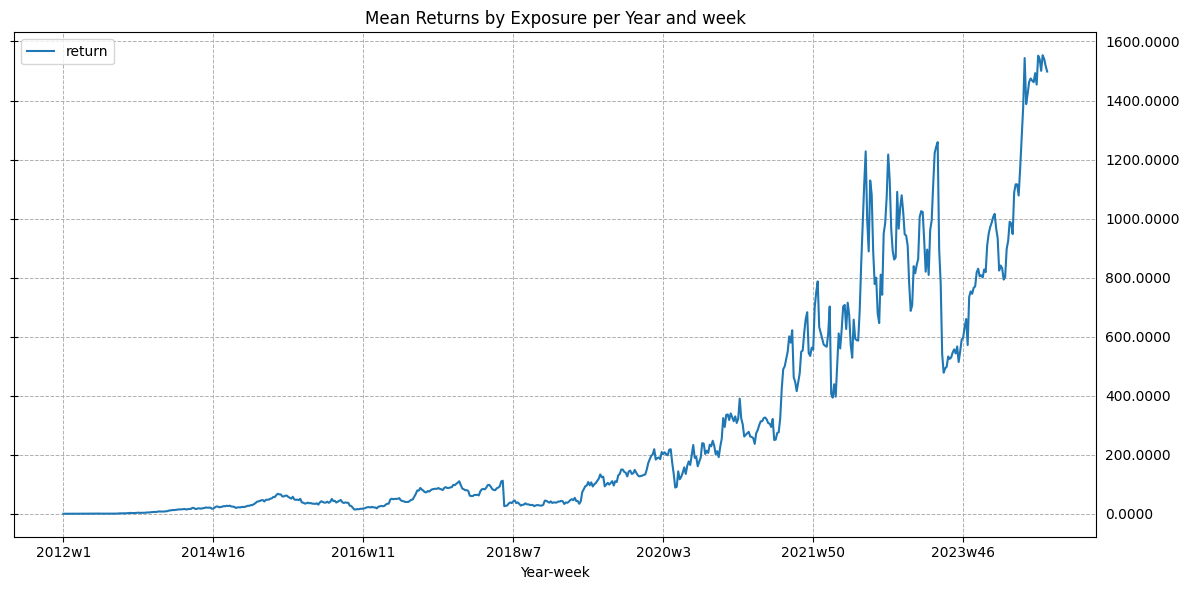

In [102]:
# Create the plot
ax = portfolio.drop(["year", "week"], axis=1).set_index("Year-week").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and week"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [103]:
portfolio.tail()

,year,week,return,Year-week
652,2024,46,1500.486473,2024w46
653,2024,47,1553.270075,2024w47
654,2024,48,1540.811236,2024w48
655,2024,49,1517.090173,2024w49
656,2024,50,1498.025287,2024w50
